# Air Pollution Index Prediction

# Problem Statment:
The air pollution index problem involves assessing and quantifying the level of air pollution based on various pollutants in the air. The goal is to create a comprehensive index that provides a clear indication of air quality, taking into account pollutants such as PM2.5, PM10, NO2, CO, SO2, O3, and others. This index should serve as a reliable measure for public awareness, health monitoring, and environmental management, helping individuals and authorities make informed decisions regarding air quality and potential health risks.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from statsmodels.stats import weightstats as stests
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")

# Loading the Dataset in CSV File


In [5]:
original_data = pd.read_csv(r"C:\Users\92348\Desktop\ML project\Machine Learning project\Air Quality Index.csv")

# 16 Features of Collected Dataset

In [6]:
original_data.columns

Index(['City', 'Date', 'PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2',
       'O3', 'Benzene', 'Toluene', 'Xylene', 'AQI', 'AQI_Bucket'],
      dtype='object')

In [7]:
original_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29531 entries, 0 to 29530
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   City        29531 non-null  object 
 1   Date        29531 non-null  object 
 2   PM2.5       24933 non-null  float64
 3   PM10        18391 non-null  float64
 4   NO          25949 non-null  float64
 5   NO2         25946 non-null  float64
 6   NOx         25346 non-null  float64
 7   NH3         19203 non-null  float64
 8   CO          27472 non-null  float64
 9   SO2         25677 non-null  float64
 10  O3          25509 non-null  float64
 11  Benzene     23908 non-null  float64
 12  Toluene     21490 non-null  float64
 13  Xylene      11422 non-null  float64
 14  AQI         24850 non-null  float64
 15  AQI_Bucket  24850 non-null  object 
dtypes: float64(13), object(3)
memory usage: 3.6+ MB


# To get description of data

In [8]:
original_data.describe()

,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI
count,24933.000000,18391.000000,25949.000000,25946.000000,25346.000000,19203.000000,27472.000000,25677.000000,25509.000000,23908.000000,21490.000000,11422.000000,24850.000000
mean,67.450578,118.127103,17.574730,28.560659,32.309123,23.483476,2.248598,14.531977,34.491430,3.280840,8.700972,3.070128,166.463581
std,64.661449,90.605110,22.785846,24.474746,31.646011,25.684275,6.962884,18.133775,21.694928,15.811136,19.969164,6.323247,140.696585
min,0.040000,0.010000,0.020000,0.010000,0.000000,0.010000,0.000000,0.010000,0.010000,0.000000,0.000000,0.000000,13.000000
25%,28.820000,56.255000,5.630000,11.750000,12.820000,8.580000,0.510000,5.670000,18.860000,0.120000,0.600000,0.140000,81.000000
50%,48.570000,95.680000,9.890000,21.690000,23.520000,15.850000,0.890000,9.160000,30.840000,1.070000,2.970000,0.980000,118.000000
75%,80.590000,149.745000,19.950000,37.620000,40.127500,30.020000,1.450000,15.220000,45.570000,3.080000,9.150000,3.350000,208.000000
max,949.990000,1000.000000,390.680000,362.210000,467.630000,352.890000,175.810000,193.860000,257.730000,455.030000,454.850000,170.370000,2049.000000


# To get null values

In [9]:
original_data.isnull().sum()

City              0
Date              0
PM2.5          4598
PM10          11140
NO             3582
NO2            3585
NOx            4185
NH3           10328
CO             2059
SO2            3854
O3             4022
Benzene        5623
Toluene        8041
Xylene        18109
AQI            4681
AQI_Bucket     4681
dtype: int64

# show the missing Data with percentage

In [10]:
missing_percentage = (original_data.isnull().mean() * 100).round(2)
missing_percentage_with_sign = missing_percentage.astype(str) + '%'
print(missing_percentage_with_sign)

City            0.0%
Date            0.0%
PM2.5         15.57%
PM10          37.72%
NO            12.13%
NO2           12.14%
NOx           14.17%
NH3           34.97%
CO             6.97%
SO2           13.05%
O3            13.62%
Benzene       19.04%
Toluene       27.23%
Xylene        61.32%
AQI           15.85%
AQI_Bucket    15.85%
dtype: object


# Overall Missing Data in the dataset

In [11]:
overall_missing_percentage = (original_data.isnull().mean().mean() * 100).round(2)
print(F"Overall Missing Data Percentage: {overall_missing_percentage}%")

Overall Missing Data Percentage: 18.73%


# Imputation

In [12]:
print("Missing values count before filling:\n", original_data.isnull().sum())

numeric_columns = original_data.select_dtypes(include=['number']).columns
original_data_filled_numeric = original_data[numeric_columns].fillna(original_data.mean())


original_data_filled_categorical = original_data['AQI_Bucket'].fillna(original_data['AQI_Bucket'].mode()[0])

# Combine the filled numeric columns and the filled categorical column
original_data_filled = pd.concat([original_data_filled_numeric, original_data_filled_categorical], axis=1)

print("\nMissing values count after filling:\n", original_data_filled.isnull().sum())


Missing values count before filling:
 City              0
Date              0
PM2.5          4598
PM10          11140
NO             3582
NO2            3585
NOx            4185
NH3           10328
CO             2059
SO2            3854
O3             4022
Benzene        5623
Toluene        8041
Xylene        18109
AQI            4681
AQI_Bucket     4681
dtype: int64

Missing values count after filling:
 PM2.5         0
PM10          0
NO            0
NO2           0
NOx           0
NH3           0
CO            0
SO2           0
O3            0
Benzene       0
Toluene       0
Xylene        0
AQI           0
AQI_Bucket    0
dtype: int64


# Checking Duplicates values

In [13]:
print("Total Duplicated Values in Dataset: \n")
original_data_filled.duplicated().sum()

Total Duplicated Values in Dataset: 



2330

In [14]:
# Check for all duplicate rows
duplicates = original_data_filled[original_data_filled.duplicated(keep=False)]

# Display duplicate rows
print("Duplicate rows:\n", duplicates.iloc[:,0:6]) # show the first five columns

Duplicate rows:
            PM2.5        PM10        NO        NO2        NOx        NH3
56     67.450578  118.127103  17.57473  28.560659  32.309123  23.483476
57     67.450578  118.127103  17.57473  28.560659  32.309123  23.483476
58     67.450578  118.127103  17.57473  28.560659  32.309123  23.483476
64     67.450578  118.127103  17.57473  28.560659  32.309123  23.483476
262    67.450578  118.127103  17.57473  28.560659  32.309123  23.483476
...          ...         ...       ...        ...        ...        ...
29226  67.450578  118.127103  17.57473  28.560659  32.309123  23.483476
29227  67.450578  118.127103  17.57473  28.560659  32.309123  23.483476
29228  67.450578  118.127103  17.57473  28.560659  32.309123  23.483476
29229  67.450578  118.127103  17.57473  28.560659  32.309123  23.483476
29463  67.450578  118.127103  17.57473  28.560659  32.309123  23.483476

[2389 rows x 6 columns]


# Removing Duplicates Values

In [15]:
print("Before the remove the Duplicates: ",original_data_filled.shape)
original_data_no_duplicates = original_data_filled.drop_duplicates()
print("After the removed the Duplicates: ",original_data_no_duplicates.shape)

Before the remove the Duplicates:  (29531, 14)
After the removed the Duplicates:  (27201, 14)


# Check the Outliers

In [16]:
numeric_columns = original_data_no_duplicates.select_dtypes(include=['number'])

# Calculate the IQR for each numeric column
Q1 = numeric_columns.quantile(0.25)
Q3 = numeric_columns.quantile(0.75)
IQR = Q3 - Q1

# Identify potential outliers
outliers = (numeric_columns < (Q1 - 1.5 * IQR)) | (numeric_columns > (Q3 + 1.5 * IQR))

# Use any() to identify rows with at least one outlier
rows_with_outliers = outliers.any(axis=1)
print("Rows with potential outliers:\n", original_data_no_duplicates[rows_with_outliers])

Rows with potential outliers:
            PM2.5        PM10      NO    NO2     NOx        NH3      CO    SO2  \
0      67.450578  118.127103    0.92  18.22   17.15  23.483476    0.92  27.64   
2      67.450578  118.127103   17.40  19.30   29.70  23.483476   17.40  29.07   
4      67.450578  118.127103   22.10  21.42   37.76  23.483476   22.10  39.33   
5      67.450578  118.127103   45.41  38.48   81.50  23.483476   45.41  45.76   
6      67.450578  118.127103  112.16  40.62  130.77  23.483476  112.16  32.28   
...          ...         ...     ...    ...     ...        ...     ...    ...   
29485   6.300000   17.760000    1.09  12.21    7.07   7.400000    0.11   8.56   
29488  66.220000  203.260000   11.97  58.99   40.98  11.850000    0.11   8.24   
29527  24.380000   74.090000    3.42  26.06   16.53  11.990000    0.52  12.72   
29528  22.910000   65.730000    3.45  29.53   18.33  10.710000    0.48   8.42   
29529  16.640000   49.970000    4.05  29.26   18.80  10.030000    0.52   9.84 

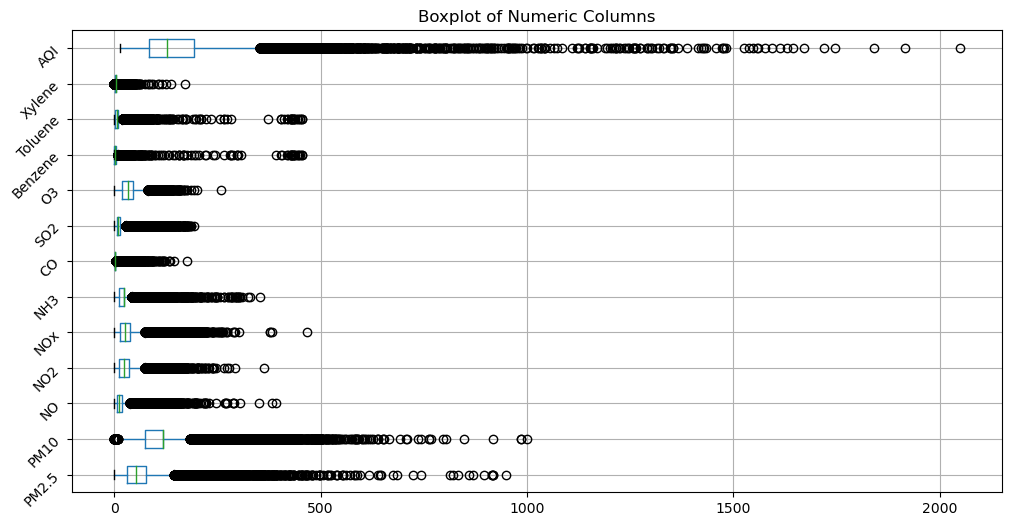

In [17]:
numeric_columns = original_data_no_duplicates.select_dtypes(include=['number'])

# Create a boxplot for each numeric column
plt.figure(figsize=(12, 6))
numeric_columns.boxplot(rot=45, vert=False)
plt.title("Boxplot of Numeric Columns")
plt.show()

#  Removing Outliers

In [18]:
print(F"Before the remove the outliers: {original_data_no_duplicates.shape}")
numeric_columns = original_data_no_duplicates.select_dtypes(include=['number'])

Q1 = numeric_columns.quantile(0.25)
Q3 = numeric_columns.quantile(0.75)
IQR = Q3 - Q1

outliers = (numeric_columns < (Q1 - 1.5 * IQR)) | (numeric_columns > (Q3 + 1.5 * IQR))

rows_with_outliers = outliers.any(axis=1)

data_without_outliers = original_data_no_duplicates[~rows_with_outliers]

print(F"After the removed the outliers: {data_without_outliers.shape}")


Before the remove the outliers: (27201, 14)
After the removed the outliers: (12097, 14)


# Data Normalization

In [19]:
numeric_columns = data_without_outliers.select_dtypes(include=['number'])

# Initialize the StandardScaler
scaler = StandardScaler()

scaled_data = scaler.fit_transform(numeric_columns)

scaled_data_df = pd.DataFrame(scaled_data, columns=numeric_columns.columns)

print("DataFrame with scaled data:\n", scaled_data_df)

DataFrame with scaled data:
           PM2.5      PM10        NO       NO2       NOx       NH3        CO  \
0      0.911096  0.741835 -1.192551 -0.411651 -0.389660  0.657492  0.150762   
1      0.911096  0.741835 -1.093644 -0.202273 -0.284270  0.657492  1.436328   
2      0.911096  0.741835  1.057205  0.554241  0.716524  0.657492  2.402436   
3      0.508394  0.741835 -1.249457 -0.967742 -0.950809  0.657492 -0.588879   
4      0.410256  0.741835 -1.010996 -0.213530 -0.097919  0.657492  2.510568   
...         ...       ...       ...       ...       ...       ...       ...   
12092 -0.377579  0.036033 -1.158679  0.165453 -0.622774 -0.278954 -0.571268   
12093 -1.191894 -0.802828 -1.012351  0.031871 -0.624868 -0.504942 -0.835426   
12094 -1.418548 -1.483819 -0.523236  0.157198 -0.338710 -0.621045 -0.747373   
12095 -1.130753 -0.999841 -0.283421  0.291530 -0.174693 -0.484209 -0.729763   
12096 -1.131531 -0.609444 -1.269780  0.425863 -0.557865 -1.237846 -0.518437   

            SO2       

# Model Selection and Application:

# Feature Selction

In [20]:
Data = original_data[['PM2.5', 'PM10', 'NO2', 'CO','SO2','O3','AQI','AQI_Bucket']]

In [21]:
Data.tail()

,PM2.5,PM10,NO2,CO,SO2,O3,AQI,AQI_Bucket
29526,15.02,50.94,25.06,0.47,8.55,23.30,41.0,Good
29527,24.38,74.09,26.06,0.52,12.72,30.14,70.0,Satisfactory
29528,22.91,65.73,29.53,0.48,8.42,30.96,68.0,Satisfactory
29529,16.64,49.97,29.26,0.52,9.84,28.30,54.0,Satisfactory
29530,15.00,66.00,26.85,0.59,2.10,17.05,50.0,Good


In [22]:
Data.shape

(29531, 8)

In [23]:
Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29531 entries, 0 to 29530
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   PM2.5       24933 non-null  float64
 1   PM10        18391 non-null  float64
 2   NO2         25946 non-null  float64
 3   CO          27472 non-null  float64
 4   SO2         25677 non-null  float64
 5   O3          25509 non-null  float64
 6   AQI         24850 non-null  float64
 7   AQI_Bucket  24850 non-null  object 
dtypes: float64(7), object(1)
memory usage: 1.8+ MB


# Selected Features Description

In [24]:
Data.describe()

,PM2.5,PM10,NO2,CO,SO2,O3,AQI
count,24933.000000,18391.000000,25946.000000,27472.000000,25677.000000,25509.000000,24850.000000
mean,67.450578,118.127103,28.560659,2.248598,14.531977,34.491430,166.463581
std,64.661449,90.605110,24.474746,6.962884,18.133775,21.694928,140.696585
min,0.040000,0.010000,0.010000,0.000000,0.010000,0.010000,13.000000
25%,28.820000,56.255000,11.750000,0.510000,5.670000,18.860000,81.000000
50%,48.570000,95.680000,21.690000,0.890000,9.160000,30.840000,118.000000
75%,80.590000,149.745000,37.620000,1.450000,15.220000,45.570000,208.000000
max,949.990000,1000.000000,362.210000,175.810000,193.860000,257.730000,2049.000000


# Null Values

In [25]:
Data.isnull().sum()

PM2.5          4598
PM10          11140
NO2            3585
CO             2059
SO2            3854
O3             4022
AQI            4681
AQI_Bucket     4681
dtype: int64

In [26]:
columns_to_fill = ['PM2.5', 'PM10', 'NO2', 'CO', 'SO2', 'O3', 'AQI']
Data = Data[columns_to_fill]

Data = Data.apply(lambda col: col.fillna(col.mean()))
print(Data)


           PM2.5        PM10    NO2     CO    SO2      O3         AQI
0      67.450578  118.127103  18.22   0.92  27.64  133.36  166.463581
1      67.450578  118.127103  15.69   0.97  24.55   34.06  166.463581
2      67.450578  118.127103  19.30  17.40  29.07   30.70  166.463581
3      67.450578  118.127103  18.48   1.70  18.59   36.08  166.463581
4      67.450578  118.127103  21.42  22.10  39.33   39.31  166.463581
...          ...         ...    ...    ...    ...     ...         ...
29526  15.020000   50.940000  25.06   0.47   8.55   23.30   41.000000
29527  24.380000   74.090000  26.06   0.52  12.72   30.14   70.000000
29528  22.910000   65.730000  29.53   0.48   8.42   30.96   68.000000
29529  16.640000   49.970000  29.26   0.52   9.84   28.30   54.000000
29530  15.000000   66.000000  26.85   0.59   2.10   17.05   50.000000

[29531 rows x 7 columns]


In [28]:
numerical_columns = ['PM2.5', 'PM10', 'NO2', 'CO', 'SO2', 'O3', 'AQI']
categorical_column = 'AQI_Bucket'

# Fill missing values in numerical columns with mean values
original_data[numerical_columns] = original_data[numerical_columns].apply(lambda col: col.fillna(col.mean()))

# Fill missing values in the categorical column with mode value
mode_value = original_data[categorical_column].mode()[0]
original_data[categorical_column] = original_data[categorical_column].fillna(mode_value)

Data = original_data[['PM2.5', 'PM10', 'NO2', 'CO','SO2','O3','AQI','AQI_Bucket']]
print(Data)


           PM2.5        PM10    NO2     CO    SO2      O3         AQI  \
0      67.450578  118.127103  18.22   0.92  27.64  133.36  166.463581   
1      67.450578  118.127103  15.69   0.97  24.55   34.06  166.463581   
2      67.450578  118.127103  19.30  17.40  29.07   30.70  166.463581   
3      67.450578  118.127103  18.48   1.70  18.59   36.08  166.463581   
4      67.450578  118.127103  21.42  22.10  39.33   39.31  166.463581   
...          ...         ...    ...    ...    ...     ...         ...   
29526  15.020000   50.940000  25.06   0.47   8.55   23.30   41.000000   
29527  24.380000   74.090000  26.06   0.52  12.72   30.14   70.000000   
29528  22.910000   65.730000  29.53   0.48   8.42   30.96   68.000000   
29529  16.640000   49.970000  29.26   0.52   9.84   28.30   54.000000   
29530  15.000000   66.000000  26.85   0.59   2.10   17.05   50.000000   

         AQI_Bucket  
0          Moderate  
1          Moderate  
2          Moderate  
3          Moderate  
4          Mo

# Fill the missing values

In [29]:
Data.isnull().sum()

PM2.5         0
PM10          0
NO2           0
CO            0
SO2           0
O3            0
AQI           0
AQI_Bucket    0
dtype: int64

# Data Preprocessing

# Dropped Missing values

In [30]:
print("Before Dropped missing values: ",Data.shape)
Data = Data.dropna()
print("After Dropped  missing values: ",Data.shape)

Before Dropped missing values:  (29531, 8)
After Dropped  missing values:  (29531, 8)


# Removing Duplicate Rows

In [31]:
Data.shape

(29531, 8)

In [32]:
Data = Data.drop_duplicates()
Data.shape

(26504, 8)

# Data Normalization

In [33]:
scaler = StandardScaler()
Scale_Data = scaler.fit_transform(Data.iloc[:,0:7])
Data.iloc[:,0:7] = Scale_Data
Data.head()

,PM2.5,PM10,NO2,CO,SO2,O3,AQI,AQI_Bucket
0,-0.000042,-0.000041,-0.427237,-0.205648,0.734384,4.645359,-0.000143,Moderate
1,-0.000042,-0.000041,-0.531727,-0.198574,0.561257,-0.020298,-0.000143,Moderate
2,-0.000042,-0.000041,-0.382633,2.126021,0.814505,-0.178169,-0.000143,Moderate
3,-0.000042,-0.000041,-0.416499,-0.095290,0.227328,0.074612,-0.000143,Moderate
4,-0.000042,-0.000041,-0.295076,2.790999,1.389356,0.226375,-0.000143,Moderate


In [34]:
Data.shape

(26504, 8)

# Handling Outliers

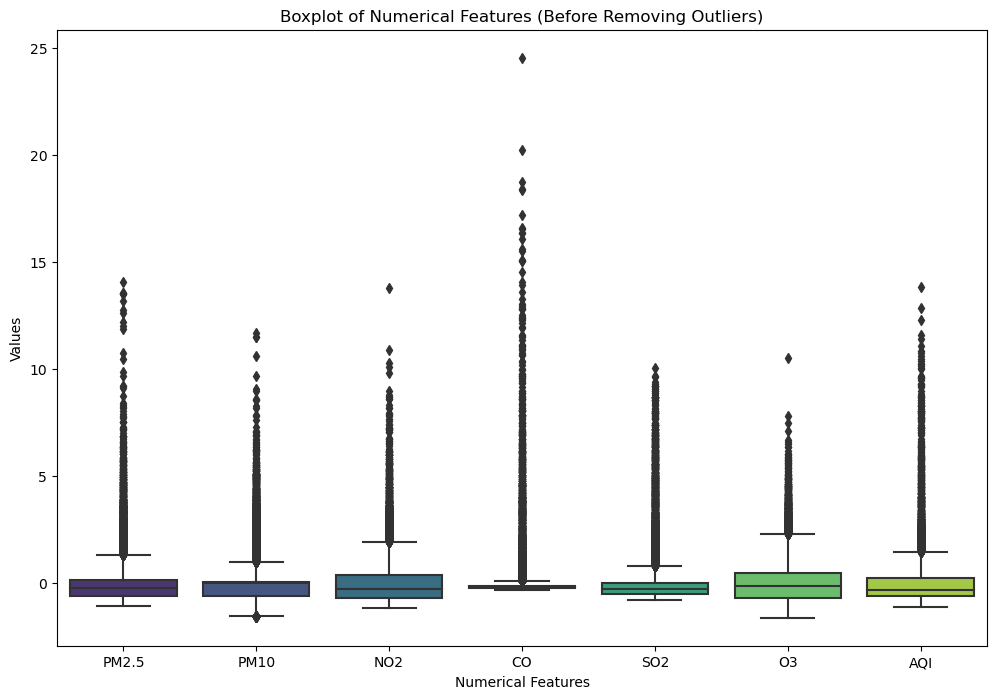

In [35]:
numerical_features = ['PM2.5', 'PM10', 'NO2', 'CO', 'SO2', 'O3','AQI']

# Create a boxplot for each numerical feature before removing outliers
plt.figure(figsize=(12, 8))
sns.boxplot(data=Data[numerical_features], palette='viridis')
plt.title('Boxplot of Numerical Features (Before Removing Outliers)')
plt.xlabel('Numerical Features')
plt.ylabel('Values')
plt.show()

In [36]:
# Remove outliers using z-score
from scipy.stats import zscore

z_scores = zscore(Data[['PM2.5', 'PM10', 'NO2', 'CO', 'SO2', 'O3']])
balanced_data = Data[abs(z_scores).all(axis=1) < 3]
balanced_data.shape

(26504, 8)

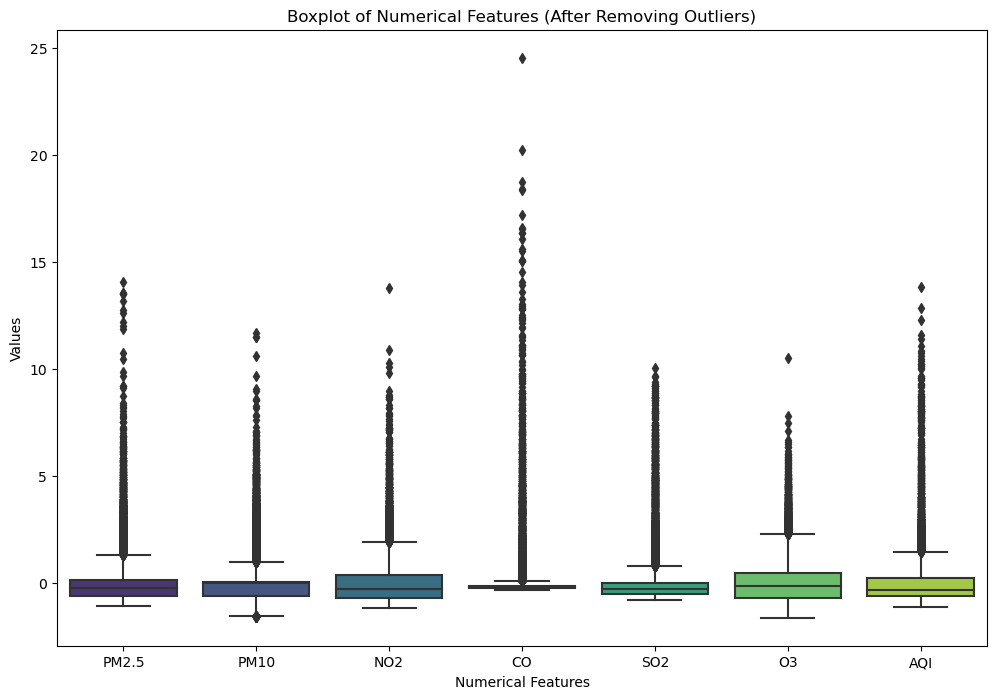

In [37]:
plt.figure(figsize=(12, 8))
sns.boxplot(data=balanced_data[numerical_features], palette='viridis')
plt.title('Boxplot of Numerical Features (After Removing Outliers)')
plt.xlabel('Numerical Features')
plt.ylabel('Values')
plt.show()


In [38]:
Data['AQI_Bucket'].value_counts()

Moderate        10488
Satisfactory     8219
Poor             2781
Very Poor        2337
Good             1341
Severe           1338
Name: AQI_Bucket, dtype: int64

In [39]:
print(Data.shape)

(26504, 8)


# data Visualization (Unbalance data)

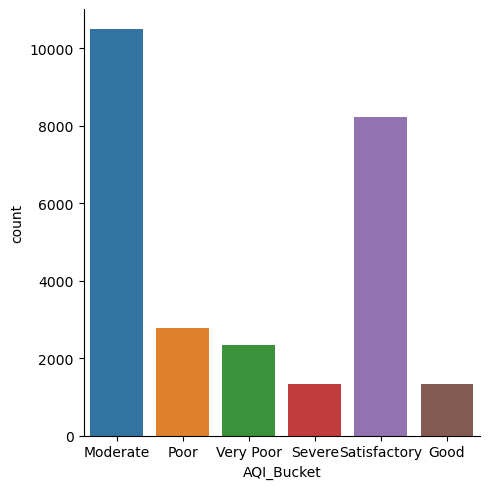

In [40]:
plot = sns.catplot(x="AQI_Bucket",data=Data,kind="count")

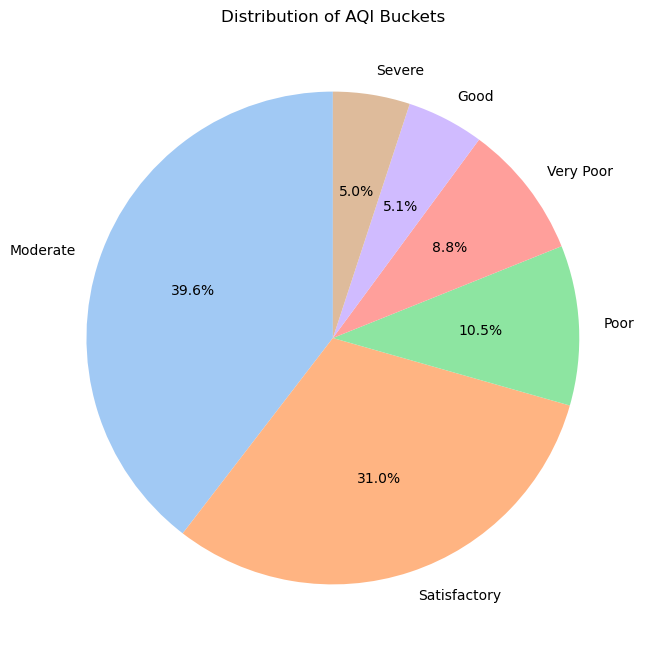

In [42]:
data_counts = Data['AQI_Bucket'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(data_counts, labels=data_counts.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette('pastel'))
plt.title('Distribution of AQI Buckets')
plt.show()


In [43]:
from sklearn.utils import resample

# Separate 'Satisfactory' and 'Moderate' classes
satisfactory_class = Data[Data['AQI_Bucket'] == 'Satisfactory']
moderate_class = Data[Data['AQI_Bucket'] == 'Moderate']

# Set the maximum number of samples to keep for each class
max_samples = 2000

# If the class has more samples than the maximum, randomly sample max_samples
if len(satisfactory_class) > max_samples:
    satisfactory_class = resample(satisfactory_class, replace=False, n_samples=max_samples, random_state=42)

if len(moderate_class) > max_samples:
    moderate_class = resample(moderate_class, replace=False, n_samples=max_samples, random_state=42)

# Combine the remaining classes
remaining_classes = Data[(Data['AQI_Bucket'] != 'Satisfactory') & (Data['AQI_Bucket'] != 'Moderate')]

# Create the final balanced dataset
balanced_data = pd.concat([satisfactory_class, moderate_class, remaining_classes])


# data Visualization (Data balanced)

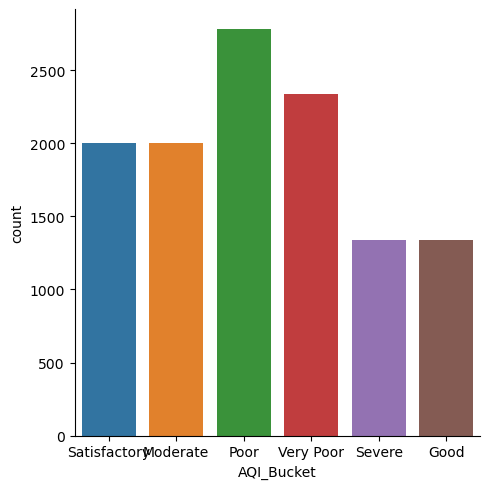

In [44]:
plot = sns.catplot(x="AQI_Bucket",data=balanced_data,kind="count")

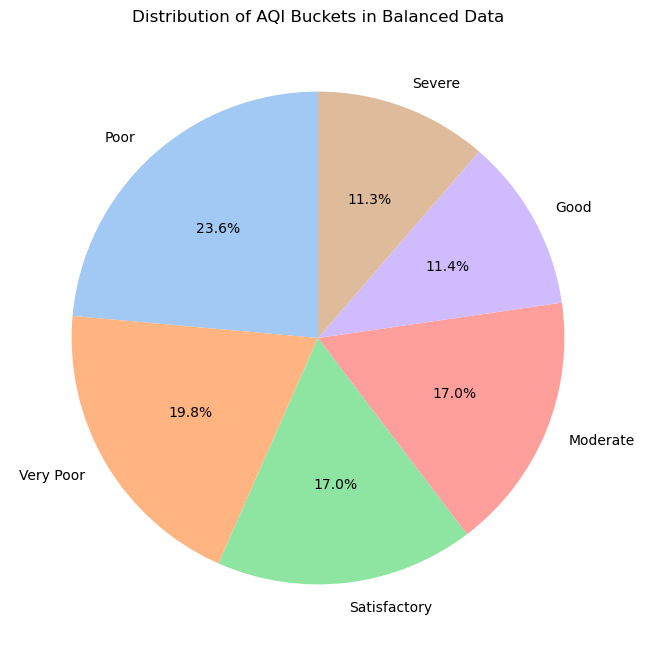

In [45]:
data_counts = balanced_data['AQI_Bucket'].value_counts()

# Creating a pie chart
plt.figure(figsize=(8, 8))
plt.pie(data_counts, labels=data_counts.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette('pastel'))
plt.title('Distribution of AQI Buckets in Balanced Data')
plt.show()

# Correlation of the variables

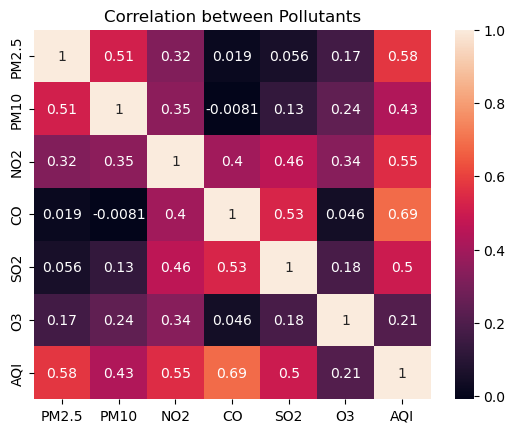

In [46]:
correlation = balanced_data[['PM2.5', 'PM10', 'NO2', 'CO','SO2','O3','AQI']].corr()
sns.heatmap(correlation, annot=True)
plt.title('Correlation between Pollutants')
plt.show()

In [47]:
balanced_data.shape

(11797, 8)

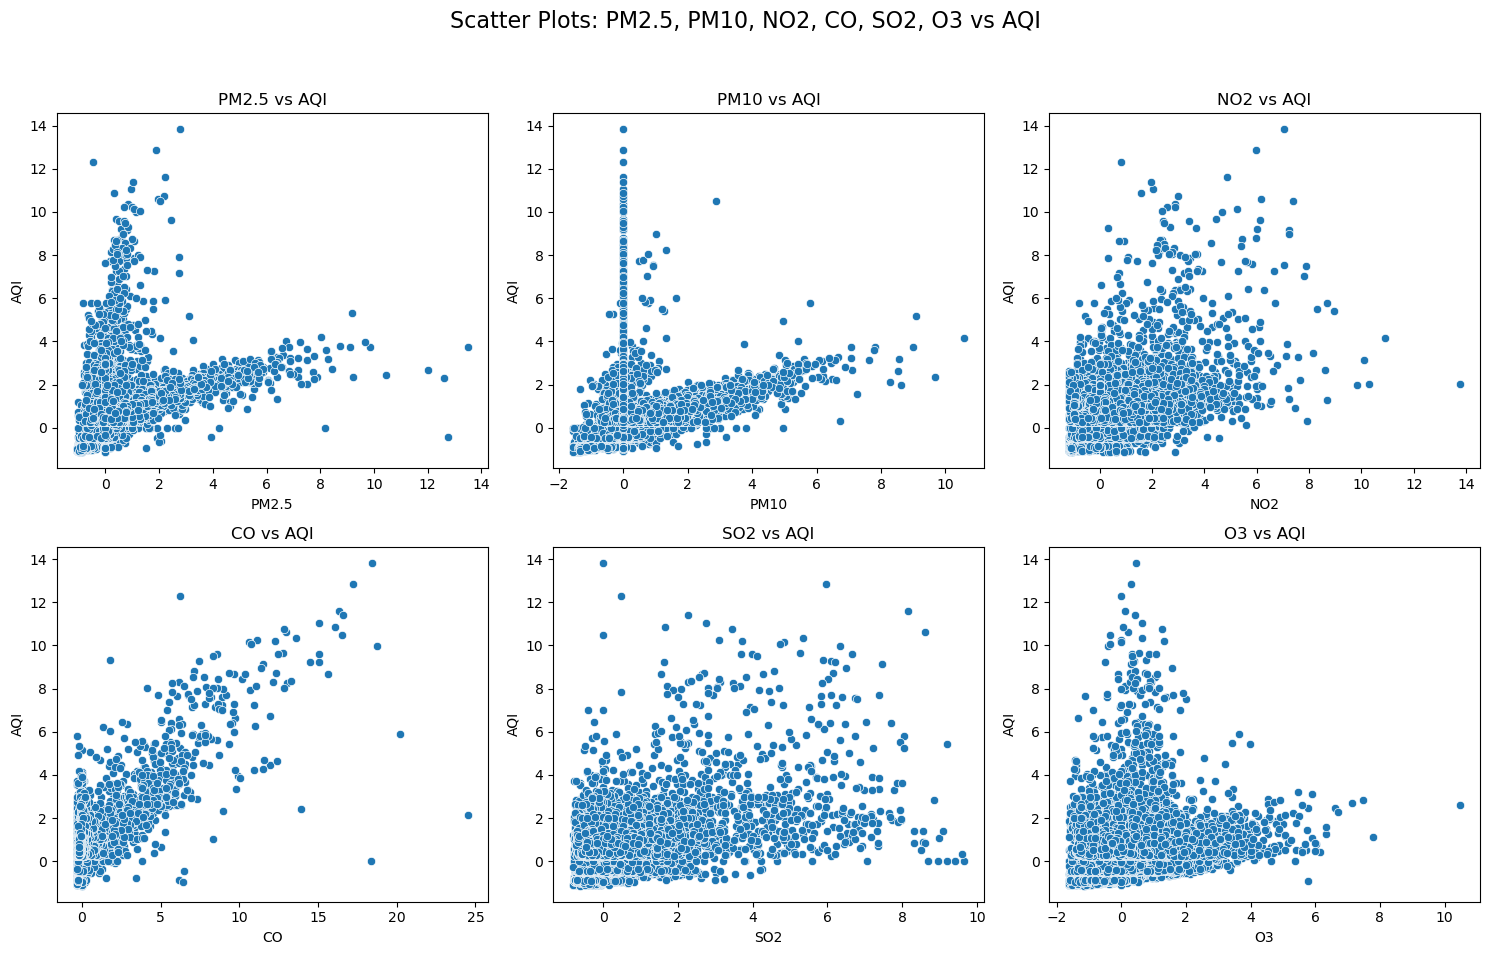

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt


features = ['PM2.5', 'PM10', 'NO2', 'CO', 'SO2', 'O3']
target_variable = 'AQI'


fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
fig.suptitle(f'Scatter Plots: {", ".join(features)} vs {target_variable}', fontsize=16)

for i, feature in enumerate(features):
    row, col = divmod(i, 3)
    sns.scatterplot(x=balanced_data[feature], y=balanced_data[target_variable], ax=axes[row, col])
    axes[row, col].set_title(f'{feature} vs {target_variable}')

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()


# Data Spliting

In [49]:
from sklearn.model_selection import train_test_split
X = balanced_data[['PM2.5', 'PM10','NO2', 'CO', 'SO2', 'O3']]
y = balanced_data["AQI"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = np.array(X_train)

# Creating Model

In [50]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor

# Train Random Forest Regression model
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

# Train Support Vector Regression model
svr_model = SVR()
svr_model.fit(X_train, y_train)

# Train Multiple Linear Regression model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

LinearRegression()

In [52]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Make predictions on the test set
rf_predictions = rf_model.predict(X_test)
svr_predictions = svr_model.predict(X_test)
linear_predictions = linear_model.predict(X_test)

# Evaluate the models
def evaluate_model(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name} Metrics:")
    print(f"MAE: {mae:.2f}")
    print(f"MSE: {mse:.2f}")
    print(f"R-squared: {r2:.4f}")
    print("\n")


evaluate_model(y_test, svr_predictions, 'Support Vector Regression')
evaluate_model(y_test, linear_predictions, 'Multiple Linear Regression')
evaluate_model(y_test, rf_predictions, 'Random Forest Regression')

Support Vector Regression Metrics:
MAE: 0.22
MSE: 0.23
R-squared: 0.8653


Multiple Linear Regression Metrics:
MAE: 0.32
MSE: 0.29
R-squared: 0.8299


Random Forest Regression Metrics:
MAE: 0.22
MSE: 0.20
R-squared: 0.8847




# Visualization of the Models Performances

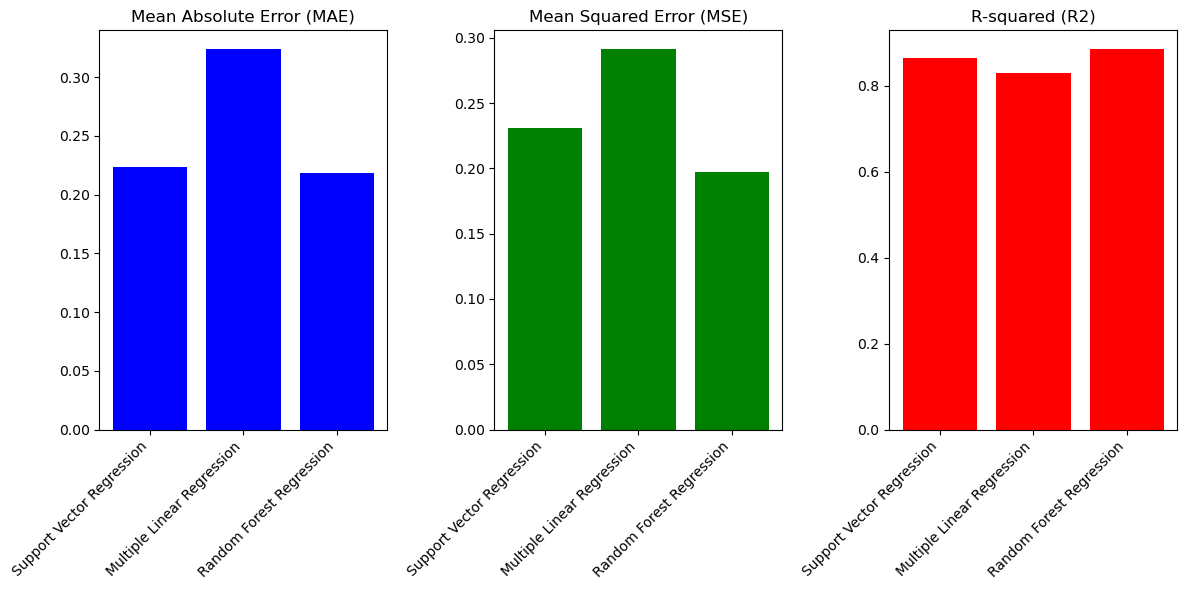

In [55]:

rf_predictions = rf_model.predict(X_test)
svr_predictions = svr_model.predict(X_test)
linear_predictions = linear_model.predict(X_test)

# Support Vector Regression
svr_mae = mean_absolute_error(y_test, svr_predictions)
svr_mse = mean_squared_error(y_test, svr_predictions)
svr_r2 = r2_score(y_test, svr_predictions)
# Multiple Linear Regression
Lr_mae = mean_absolute_error(y_test, linear_predictions)
Lr_mse = mean_squared_error(y_test, linear_predictions)
Lr_r2 = r2_score(y_test, linear_predictions)

# Multiple Linear Regression
Rf_mae = mean_absolute_error(y_test, rf_predictions)
Rf_mse = mean_squared_error(y_test, rf_predictions)
Rf_r2 = r2_score(y_test, rf_predictions)


model_names = ['Support Vector Regression', 'Multiple Linear Regression', 'Random Forest Regression']

mae_values = [svr_mae, Lr_mae, Rf_mae]
mse_values = [svr_mse, Lr_mse, Rf_mse]
r2_values = [svr_r2, Lr_r2, Rf_r2]

# Create a bar plot for MAE
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.bar(model_names, mae_values, color='blue')
plt.title('Mean Absolute Error (MAE)')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels

# Create a bar plot for MSE
plt.subplot(1, 3, 2)
plt.bar(model_names, mse_values, color='green')
plt.title('Mean Squared Error (MSE)')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels

# Create a bar plot for R-squared
plt.subplot(1, 3, 3)
plt.bar(model_names, r2_values, color='red')
plt.title('R-squared (R2)')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels

plt.tight_layout()
plt.show()

# Alternative Methodology other models apply like Xgboost and MLP Regressor

# Multi-layer Perceptron Regressor (Neural Network)

In [57]:
from sklearn.neural_network import MLPRegressor
mlp_model = MLPRegressor(hidden_layer_sizes=(64, 32), activation='relu', random_state=42, max_iter=1000)

X_train, X_test, y_train, y_test
mlp_model.fit(X_train, y_train)

MLP_y_pred = mlp_model.predict(X_test)

# Evaluate the models
def evaluate_model(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name} Metrics:")
    print(f"MAE: {mae:.2f}")
    print(f"MSE: {mse:.2f}")
    print(f"R-squared: {r2:.4f}")
    print("\n")

evaluate_model(y_test, MLP_y_pred, 'MLPRegressor')

MLPRegressor Metrics:
MAE: 0.25
MSE: 0.20
R-squared: 0.8805




# XGBoost Regression

In [58]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

xgb_model = XGBRegressor(random_state=42)
xgb_model.fit(X_train, y_train)

xgb_predictions = xgb_model.predict(X_test)

# Evaluate the models
def evaluate_model(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name} Metrics:")
    print(f"MAE: {mae:.2f}")
    print(f"MSE: {mse:.2f}")
    print(f"R-squared: {r2:.4f}")
    print("\n")

evaluate_model(y_test, xgb_predictions, 'XGBoost Regression')

XGBoost Regression Metrics:
MAE: 0.23
MSE: 0.20
R-squared: 0.8818




# Result of Model

In [59]:
evaluate_model(y_test, svr_predictions, 'Support Vector Regression')
evaluate_model(y_test, linear_predictions, 'Multiple Linear Regression')
evaluate_model(y_test, rf_predictions, 'Random Forest Regression')
evaluate_model(y_test, xgb_predictions, 'XGBoost Regression')
evaluate_model(y_test, MLP_y_pred, 'MLP Regressor')

Support Vector Regression Metrics:
MAE: 0.22
MSE: 0.23
R-squared: 0.8653


Multiple Linear Regression Metrics:
MAE: 0.32
MSE: 0.29
R-squared: 0.8299


Random Forest Regression Metrics:
MAE: 0.22
MSE: 0.20
R-squared: 0.8847


XGBoost Regression Metrics:
MAE: 0.23
MSE: 0.20
R-squared: 0.8818


MLP Regressor Metrics:
MAE: 0.25
MSE: 0.20
R-squared: 0.8805




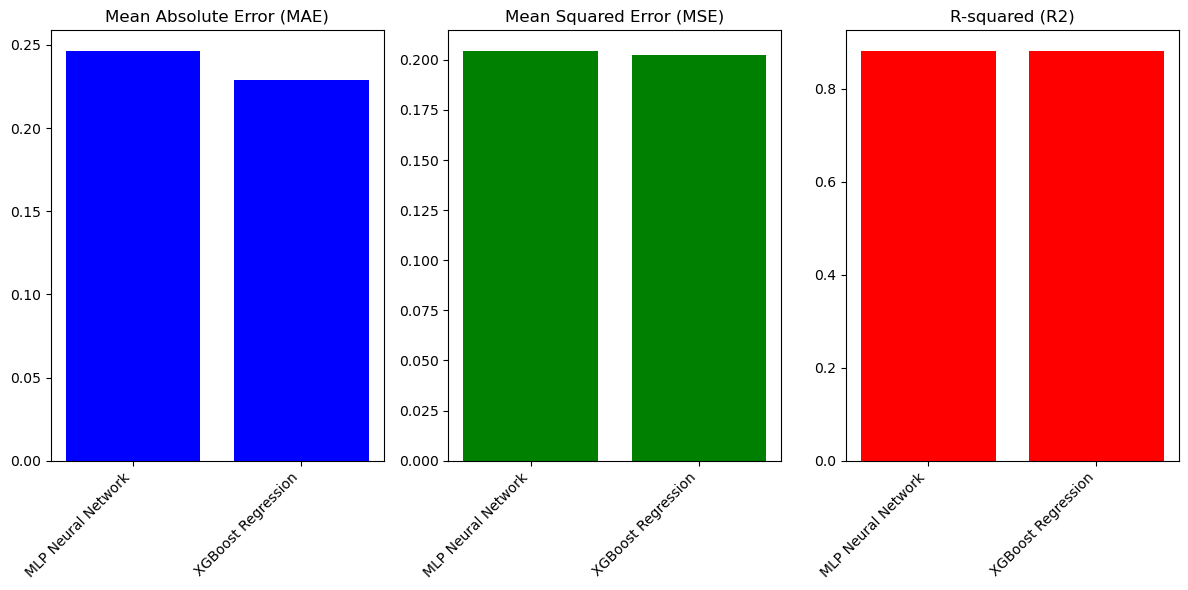

In [60]:
MLP_y_pred = mlp_model.predict(X_test)
xgb_predictions = xgb_model.predict(X_test)

# MLP Neural Network
MLP_mae = mean_absolute_error(y_test, MLP_y_pred)
MLP_mse = mean_squared_error(y_test, MLP_y_pred)
MLP_r2 = r2_score(y_test, MLP_y_pred)
# XGboost Regression
XGB_mae = mean_absolute_error(y_test, xgb_predictions)
XGB_mse = mean_squared_error(y_test, xgb_predictions)
XGB_r2 = r2_score(y_test, xgb_predictions)


model_names = ['MLP Neural Network','XGBoost Regression']

mae_values = [MLP_mae, XGB_mae]
mse_values = [MLP_mse, XGB_mse]
r2_values = [MLP_r2, XGB_r2]

# Create a bar plot for MAE
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.bar(model_names, mae_values, color='blue')
plt.title('Mean Absolute Error (MAE)')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels

# Create a bar plot for MSE
plt.subplot(1, 3, 2)
plt.bar(model_names, mse_values, color='green')
plt.title('Mean Squared Error (MSE)')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels

# Create a bar plot for R-squared
plt.subplot(1, 3, 3)
plt.bar(model_names, r2_values, color='red')
plt.title('R-squared (R2)')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels

plt.tight_layout()
plt.show()